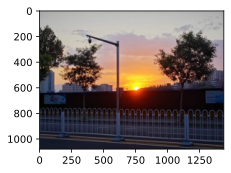

In [6]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.Image.open('img/6.jpg')
d2l.plt.imshow(img);

In [ ]:
def apply(img, aug, num_rows=2, num_cols=4, scale = 1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols,scale=scale)

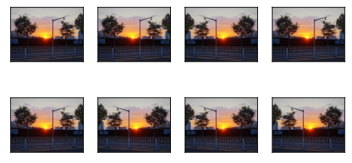

In [7]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

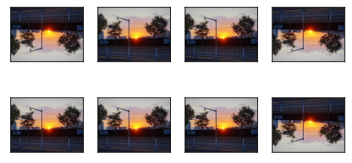

In [8]:
apply(img, torchvision.transforms.RandomVerticalFlip())

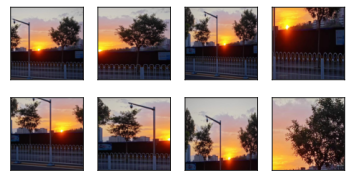

In [9]:
shape_aug = torchvision.transforms.RandomResizedCrop((200,200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

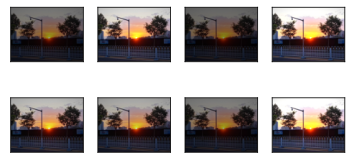

In [10]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0
))
# 上下 50%

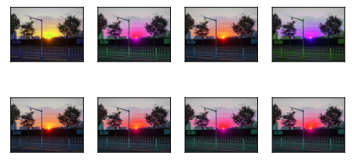

In [11]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5
))
#随机改变色调

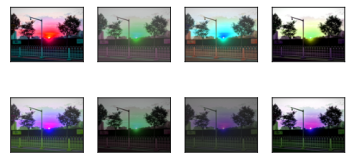

In [12]:
#亮度 对比度 饱和度 色调
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
))

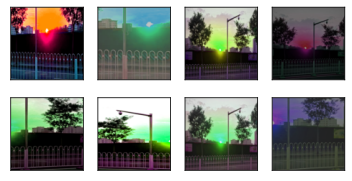

In [15]:
# 结合多种图像增广方法
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)

augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    color_aug, shape_aug
])
apply(img,augs)

Using downloaded and verified file: ./data\cifar-10-python.tar.gz
Extracting ./data\cifar-10-python.tar.gz to ./data


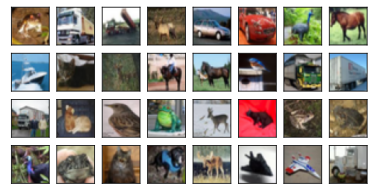

In [28]:
# 使用图像增广进行训练
all_images = torchvision.datasets.CIFAR10(
    train=True, root="./data",download=True
)

d2l.show_images([
    all_images[i][0] for i in range (32)], 4, 8, scale=0.8);

In [29]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [31]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(
        root = './data', train = is_train,
        transform=augs, download=True
    )
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle = is_train,
        num_workers=4
    )
    return dataloader

In [32]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum



In [35]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.175, train acc 0.940, test acc 0.810
801.9 examples/sec on [device(type='cuda', index=0)]


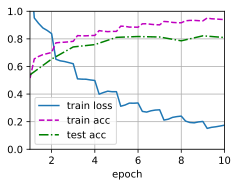

In [36]:
train_with_data_aug(train_augs, test_augs, net)